<a href="https://colab.research.google.com/github/mu06905/MLP_GAN/blob/main/MLP_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MLP GAN on MNIST Dataset
*Maha Usmani*

## Theory

For this assignment, I have used a simple MLP GAN architecture that consists of fully connected layers.

**Generator:**

The input layer takes randomk noise which is passed through 3 fully connected hidden layers. After each layer there is a batch normalization which normalizes the internal covariant shift and helps improving the training process. Relu activation function has gained popularity due to its simplicity.

**Discriminator:**

The Discriminator starts with an input layer that takes an image as input. Each image in the MNIST dataset has size 28 * 28 pixels and contains a single channel. The input image is then passed through a series of fully connected layers. For the activation function, Leaky ReLU is used which prevents 'dead neurons'.

The final layer of the Discriminator is a fully connected layer with a single neuron. This layer produces the discriminator's output, which is a probability score representing the likelihood of the input image being real (closer to 1) or fake (closer to 0).

The dataset used consists of single-channel images of small size that is why I have used MLP model with comparitively few numbber of parameters. For more comples dataset, CGANs would be a better choice. CGANs consist of convolution layers that are better at detecting complex patterns in images.


**Training Process Documentation:**

**Loss Function:**
For the Generator and Discriminator in the GAN, we use the Binary Cross Entropy with Logits Loss (BCEWithLogitsLoss). This loss function is commonly used in GANs for binary classification tasks, where the model outputs logits (real numbers) instead of probabilities. The BCEWithLogitsLoss combines a sigmoid activation function and the binary cross-entropy loss, providing better numerical stability during training. It helps prevent issues like vanishing gradients and saturating activations.

However, BCE loss can cause mode collapse and a might not be appropriate for complex problems.

**Learning Rate:**
The learning rate is set to 0.00001 for both the Generator and Discriminator. I chose a small learning rate to ensure stable and slow updates.

**Optimizer:**
I have used Adam optimizer for both Generator and Discriminator model.  It is well-suited for GANs as it helps to converge faster and provides good generalization.

**Batch Normalization:**
Batch normalization helps reduce internal covariate shift and ensures that the distribution of the weights does not fluctuate.


**Steps for deploying the GAN to a cloud-based service:**

1- Save the trained models parameters.

2- Create a virtual environment on the hosting website and install dependencies.

3- Set up an API on Flask. (I have previously worked with Flask APIs).

4- Load the  model

5- Return the generated images as response from the API.



## Imports

In [ ]:
!pip install pytorch-fid

In [2]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from pytorch_fid import fid_score
torch.manual_seed(0)

## Model Architechture

In [3]:
import numpy as np
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy.random import random
from scipy.linalg import sqrtm

In [4]:
class Generator(nn.Module):
  def __init__(self, z_dim=10, im_dim=784, hidden_dim=128):
        super(Generator, self).__init__()

        self.gen = nn.Sequential(
            nn.Linear(z_dim, hidden_dim),             # input layer
            nn.BatchNorm1d(hidden_dim),               # batch normalization
            nn.ReLU(inplace=True),                    # activation

            nn.Linear(hidden_dim, hidden_dim * 2),    # hidden layer
            nn.BatchNorm1d(hidden_dim * 2),
            nn.ReLU(inplace=True),

            nn.Linear(hidden_dim * 2, hidden_dim * 4),
            nn.BatchNorm1d(hidden_dim * 4),
            nn.ReLU(inplace=True),

            nn.Linear(hidden_dim * 4, hidden_dim * 8),
            nn.BatchNorm1d(hidden_dim * 8),
            nn.ReLU(inplace=True),

            nn.Linear(hidden_dim * 8, im_dim),        # output layer
            nn.Sigmoid()
        )
  def forward(self, noise):
        return self.gen(noise)

class Discriminator(nn.Module):

    def __init__(self, im_dim=784, hidden_dim=128):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Linear(im_dim, hidden_dim * 4),        # input layer
            nn.LeakyReLU(0.2, inplace = True),        # activation
            nn.Linear(hidden_dim*4, hidden_dim * 2),  # hidden layer
            nn.LeakyReLU(0.2, inplace = True),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Linear(hidden_dim, 1)                  # output layer
        )

    def forward(self, image):
        return self.disc(image)

def get_discriminator_loss(generator, discriminator, criterion, real, num_images, z_dim, device):
    # Generate fake images using the generator
    fake_noise = torch.randn(num_images,z_dim,device = device)
    fake = generator(fake_noise)

    # Calculate discriminator loss for fake and real images
    discriminator_fake_pred = discriminator(fake.detach())
    discriminator_fake_loss = criterion(discriminator_fake_pred, torch.zeros_like(discriminator_fake_pred))
    discriminator_real_pred = discriminator(real)

    # Average the discriminator losses
    discriminator_real_loss = criterion(discriminator_real_pred, torch.ones_like(discriminator_real_pred))
    discriminator_loss = (discriminator_fake_loss + discriminator_real_loss) / 2
    return discriminator_loss

def get_generator_loss(generator, discriminator, criterion, num_images, z_dim, device):
    # Generate fake images using the generator
    fake_noise = torch.randn(num_images,z_dim,device = device)
    fake = generator(fake_noise)

    # Calculate generator loss
    discriminator_fake_pred = discriminator(fake)
    generator_loss = criterion(discriminator_fake_pred, torch.ones_like(discriminator_fake_pred))
    return generator_loss


# calculate frechet inception distance
#source: https://machinelearningmastery.com/how-to-implement-the-frechet-inception-distance-fid-from-scratch/
def calculate_fid(act1, act2):
    # Move tensors to CPU
    act1 = act1.cpu().detach().numpy()
    act2 = act2.cpu().detach().numpy()

    # calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)

    # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)

    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))

    # check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    # calculate score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

In [ ]:
#constants
num_images = 25
size = (1, 28, 28)
criterion = nn.BCEWithLogitsLoss()
n_epochs = 200
z_dim = 64
batch_size = 128
lr = 0.00001
device = 'cuda'

dataloader = DataLoader(
    MNIST('.', download=True, transform=transforms.ToTensor()),
    batch_size=batch_size,
    shuffle=True)


generator = Generator(z_dim).to(device)
generator_opt = torch.optim.Adam(generator.parameters(), lr=lr)
discriminator = Discriminator().to(device)
discriminator_opt = torch.optim.Adam(discriminator.parameters(), lr=lr)
gen_loss = False
num_fid_samples = 500

## Training

In [6]:
import matplotlib.pyplot as plt

# Lists to store generator and discriminator losses
generator_losses = []
discriminator_losses = []
i = 0
# Training loop
for epoch in range(n_epochs):
    for batch, _ in tqdm(dataloader):
        batch_size = len(batch)
        batch = batch.view(batch_size, -1).to(device)
        discriminator_opt.zero_grad()
        discriminator_loss = get_discriminator_loss(generator, discriminator, criterion, batch, batch_size, z_dim, device)

        # update parameters
        discriminator_loss.backward(retain_graph=True)
        discriminator_opt.step()

        generator_opt.zero_grad()
        generator_loss = get_generator_loss(generator, discriminator, criterion, batch_size, z_dim, device)

        # update parameters
        generator_loss.backward()
        generator_opt.step()

        # Store the losses for plotting
        generator_losses.append(generator_loss.item())
        discriminator_losses.append(discriminator_loss.item())
        if i % 500 == 0:
          fake_noise = torch.randn(num_images,z_dim,device = device)
          fake = generator(fake_noise)
          print("FID score:", calculate_fid(batch, fake))
        i+=1


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 182.76032079003923


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 65.78710657193952


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 60.534844383486345


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 52.25355444234117


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 54.832075127667366


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 54.269071438821896


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 51.35785442611812


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 51.85037609158411


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 48.316905482995246


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 46.313710758176754


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 45.22598751409376


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 47.72364968540958


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 46.88070491143762


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 44.921234233373845


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 48.880495314135445


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 48.854547070938565


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 48.200920426297394


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 44.05099339104841


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 45.255157237209914


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 47.048789402058276


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 47.48985516795892


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 50.17153504319198


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 50.31421215395878


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 49.007987618013615


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 47.32698631181093


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 43.10592371216495


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 47.63336192494281


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 48.582851574186165


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 47.765860188457324


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 45.63319404799039


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 50.77086019164396


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 50.75457054833034


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 48.04181487890053


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 48.25801364481581


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 46.499598507997575


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 47.50234605467949


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 47.711418502912466


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 47.513307933535515


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 47.09617748898283


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 47.92114724431624


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 43.80010089509389


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 46.77844812675637


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 46.91836981332315


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 46.93807385766829


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 44.47311737178795


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 46.90673937944143


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 43.78337036956661


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 45.43694812546081


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 47.20153133067514


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 47.23387958540992


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 45.97852524076711


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 49.097583529766005


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 51.054045164472655


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 43.00621886513334


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 49.116035390930804


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 50.50155379961773


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 52.665150355409914


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 47.162270132502144


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 48.42946793752738


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 44.89477085080717


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 49.3904971713913


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 47.80277037384235


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 48.48017355241997


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 47.65036140994957


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 48.08535462845691


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 48.13245763529718


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 49.75097590265602


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 52.453350819528765


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 51.14039587304148


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 45.852281191012494


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 46.27655649816053


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 47.10168229464864


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 44.45239958436625


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 50.26991726082106


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 51.10119714372227


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 47.11920838945746


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 50.37841572727932


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 50.47478628536773


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 48.731066772213005


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 48.801677444175255


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 49.291861973749356


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 50.984117474290436


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 45.2475846221135


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 46.811764134647945


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 45.66810195313752


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 49.35316177886247


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 46.39391322106003


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 43.70480370298695


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 47.311605576357884


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 46.02351617609539


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 51.03737023385829


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 45.31111730969141


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 44.75354705837767


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 45.639248516050685


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 49.72033968780476


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 46.521823117937565


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 45.7531484732683


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 48.77011872604982


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 47.387642447929


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 49.10859072447989


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 50.060754852819485


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 52.40876690996453


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 48.18714205191887


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 46.599228346102706


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 47.4520728932021


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 45.49786908846956


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 48.25542223869476


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 48.25568767116136


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 48.8986459562619


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 47.864624524868766


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 48.10249431078397


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 45.65111470327581


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 46.25148810915303


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 47.926002007915855


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 44.70446013825745


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 46.296174177941126


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 46.359346580551346


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 41.83580465653464


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 46.426962542867386


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 43.41451769419217


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 42.19198848442944


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 46.00344235600089


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 40.927054942116136


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 42.498403120535016


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 42.84284841068412


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 44.782609360753824


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 46.97335404666015


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 43.23147749548541


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 44.27849601868952


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 50.14245958452615


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 48.500266661306554


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 45.78089558568542


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 42.47873779050312


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 43.279595832491935


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 46.58788411636728


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 48.04947237747099


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 44.218967115222654


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 42.04516197699636


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 42.537197073942906


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 44.26322407392446


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 43.34524284938831


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 44.792307919984076


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 41.321763583541966


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 44.27292419159118


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 45.20593482999671


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 44.00536054284247


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 46.70641662689819


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 43.43031090782187


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 42.58066352548202


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 49.90730255319901


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 47.15964092924363


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 44.19605639037351


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 43.82100505598923


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 48.41520363564146


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 44.042722552762356


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 42.883924606826156


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 43.03398683675794


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 42.41300576665502


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 46.58083890814164


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 45.96751663337443


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 47.10743967002834


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 48.560817368001636


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 44.260991455434635


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 47.01943822527602


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 45.569369915803954


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 47.606347876637


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 45.02355640220652


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 45.0828816204479


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 48.2807302127646


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 47.733308747754634


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 45.44318511570955


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 46.15389603134232


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 48.85688571701695


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 42.912692376807925


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 48.70478895467223


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 45.97277303557324


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 44.73581865429719


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 44.73842600470614


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 45.1361211664612


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 44.469400691783804


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 43.73203824300718


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 46.74238776596789


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 46.43450824295769


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 44.974848699980825


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 46.80472120464077


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 45.913261500074135


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 46.16753524288569


  0%|          | 0/469 [00:00<?, ?it/s]

FID score: 43.78312666731382


## Results


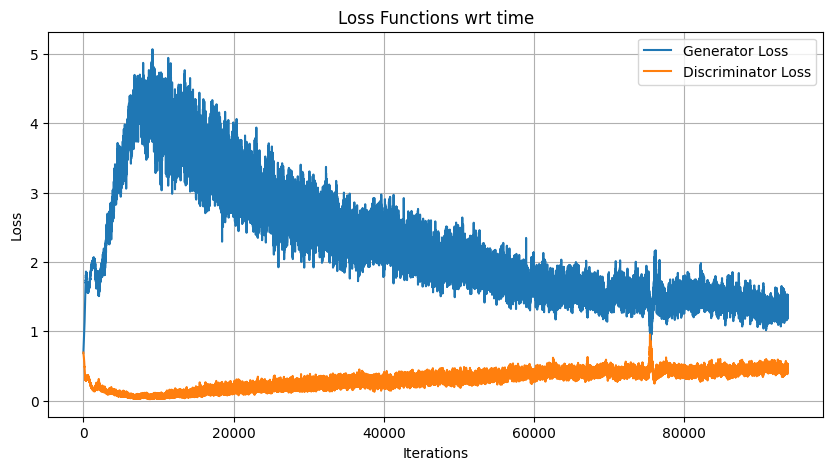

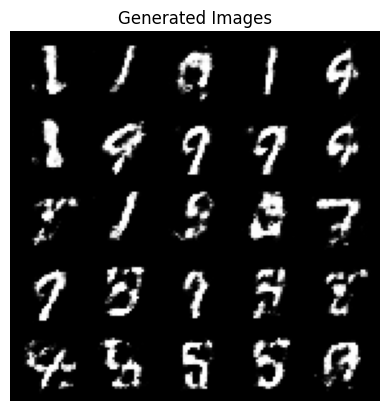

In [7]:
# Plot the generator and discriminator losses over time
plt.figure(figsize=(10, 5))
plt.plot(generator_losses, label='Generator Loss')
plt.plot(discriminator_losses, label='Discriminator Loss')
plt.title('Loss Functions wrt time')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Display generated images
noise = torch.randn(batch_size, z_dim, device=device)
fake = generator(noise)
image_unflat = fake.detach().cpu().view(-1, *size)
image_grid = make_grid(image_unflat[:num_images], nrow=5)
plt.imshow(image_grid.permute(1, 2, 0).squeeze())
plt.axis('off')
plt.title('Generated Images')
plt.show()

